# Visualizing CNN Layers
---
In this notebook, we load a trained CNN (from a solution to FashionMNIST) and implement several feature visualization techniques to see what features this network has learned to extract.

### Load the [data](http://pytorch.org/docs/master/torchvision/datasets.html)

In this cell, we load in just the **test** dataset from the FashionMNIST class.

In [1]:
# our basic libraries
import torch
import torchvision

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors for input into a CNN

## Define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

test_data = FashionMNIST(root='./data', train=False,
                                  download=True, transform=data_transform)


# Print out some stats about the test data
print('Test data, number of images: ', len(test_data))

Test data, number of images:  10000


In [2]:
# prepare data loaders, set the batch_size
## TODO: you can try changing the batch_size to be larger or smaller
## when you get to training your network, see how batch_size affects the loss
batch_size = 20

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualize some test data

This cell iterates over the training dataset, loading a random batch of image/label data, using `dataiter.next()`. It then plots the batch of images and labels in a `2 x batch_size/2` grid.

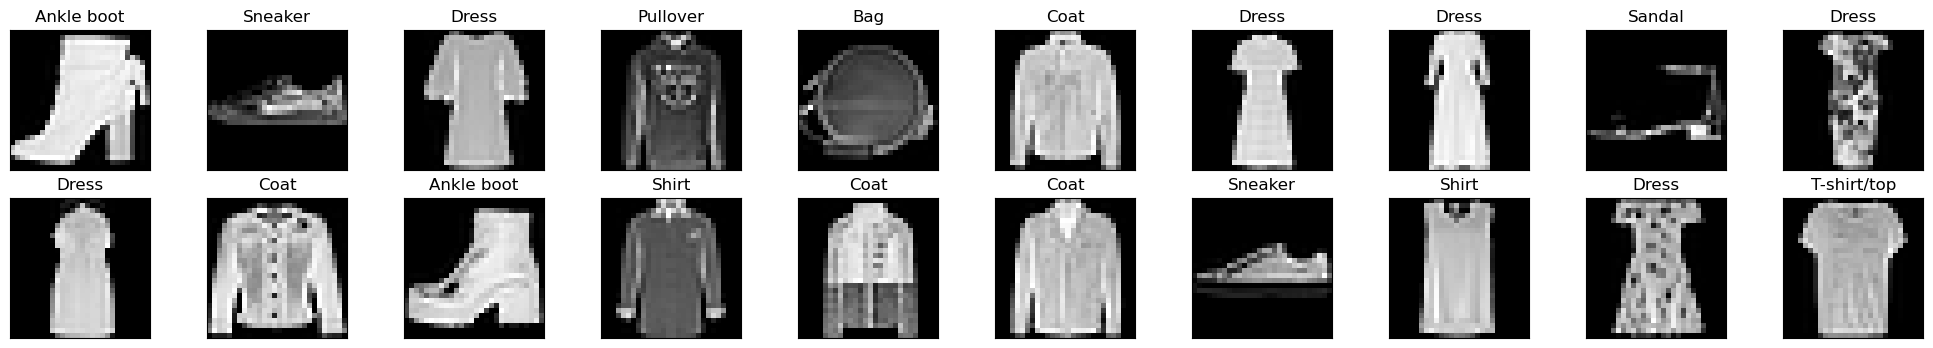

In [4]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, int(batch_size/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

### Define the network architecture

The various layers that make up any neural network are documented, [here](http://pytorch.org/docs/master/nn.html). For a convolutional neural network, we'll use a simple series of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected (linear) layers

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        ## output size = (W-F)/S +1 = (28-3)/1 +1 = 26
        # the output Tensor for one image, will have the dimensions: (10, 26, 26)
        # after one pool layer, this becomes (10, 13, 13)
        self.conv1 = nn.Conv2d(1, 10, 3)
        
        # maxpool layer
        # pool with kernel_size=2, stride=2
        self.pool = nn.MaxPool2d(2, 2)
        
        # second conv layer: 10 inputs, 20 outputs, 3x3 conv
        ## output size = (W-F)/S +1 = (13-3)/1 +1 = 11
        # the output tensor will have dimensions: (20, 11, 11)
        # after another pool layer this becomes (20, 5, 5); 5.5 is rounded down
        self.conv2 = nn.Conv2d(10, 20, 3)
        
        # 20 outputs * the 5*5 filtered/pooled map size
        self.fc1 = nn.Linear(20*5*5, 50)
        
        # dropout with p=0.4
        self.fc1_drop = nn.Dropout(p=0.4)
        
        # finally, create 10 output channels (for the 10 classes)
        self.fc2 = nn.Linear(50, 10)

    # define the feedforward behavior
    def forward(self, x):
        # two conv/relu + pool layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # prep for linear layer
        # this line of code is the equivalent of Flatten in Keras
        x = x.view(x.size(0), -1)
        
        # two linear layers with dropout in between
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        
        # final output
        return x


### Load in our trained net

This notebook needs to know the network architecture, as defined above, and once it knows what the "Net" class looks like, we can instantiate a model and load in an already trained network.

The architecture above is taken from the example solution code, which was trained and saved in the directory `saved_models/`.


In [6]:
# instantiate your Net
net = Net()

# load the net parameters by name
net.load_state_dict(torch.load('saved_models/fashion_net_ex.pt'))

print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. These techniques are called feature visualization and they are useful for understanding the inner workings of a CNN.

In the cell below, you'll see how to extract and visualize the filter weights for all of the filters in the first convolutional layer.

Note the patterns of light and dark pixels and see if you can tell what a particular filter is detecting. For example, the filter pictured in the example below has dark pixels on either side and light pixels in the middle column, and so it may be detecting vertical edges.

<img src='images/edge_filter_ex.png' width= 30% height=30%/>



First convolutional layer


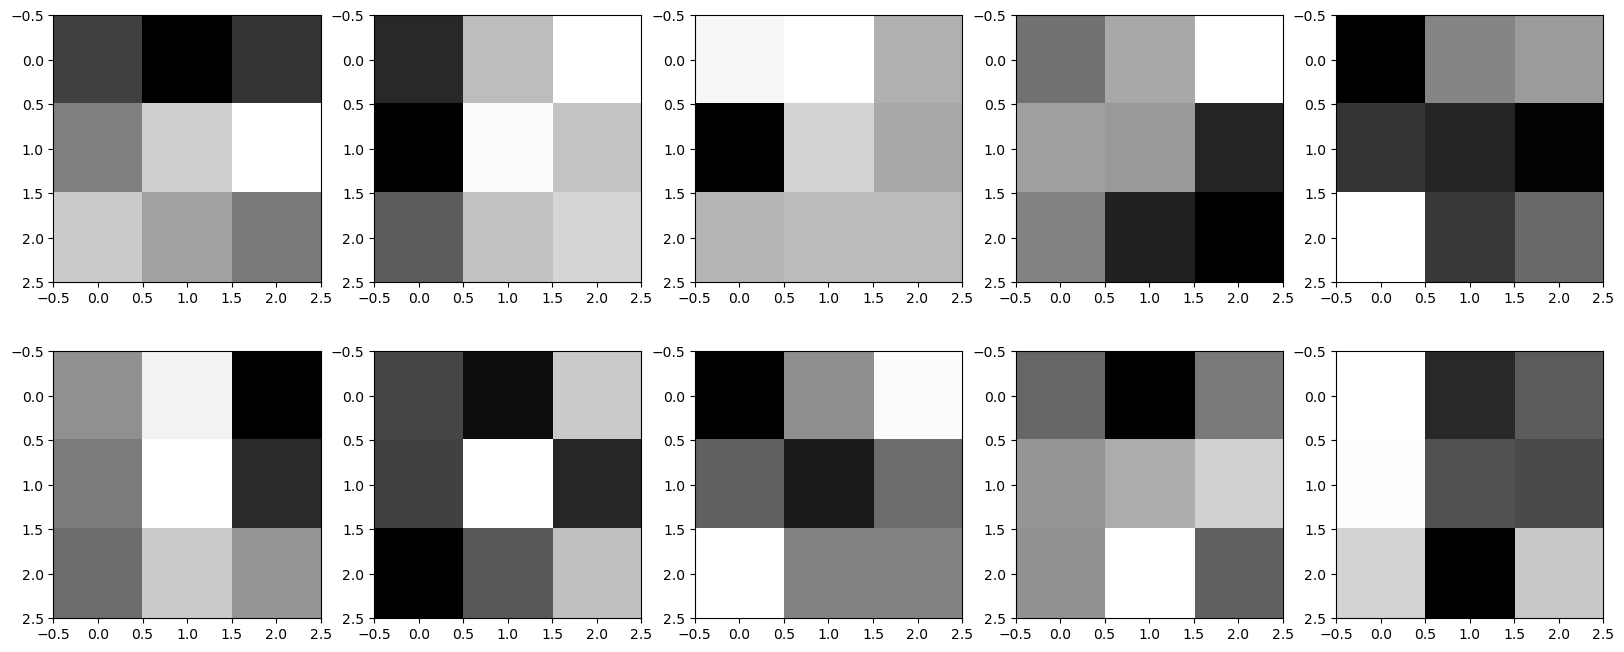

In [7]:
# Get the weights in the first conv layer
weights = net.conv1.weight.data
w = weights.numpy()

# for 10 filters
fig=plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    
print('First convolutional layer')
plt.show()

weights = net.conv2.weight.data
w = weights.numpy()

### Activation Maps

Next, you'll see how to use OpenCV's `filter2D` function to apply these filters to a sample test image and produce a series of **activation maps** as a result. We'll do this for the first and second convolutional layers and these activation maps whould really give you a sense for what features each filter learns to extract.

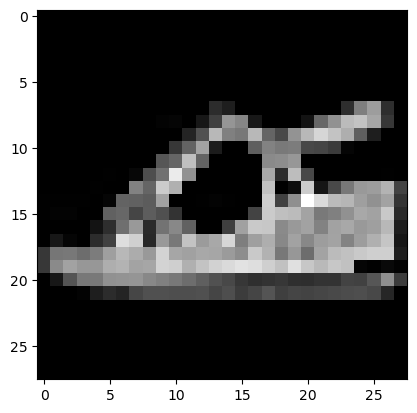

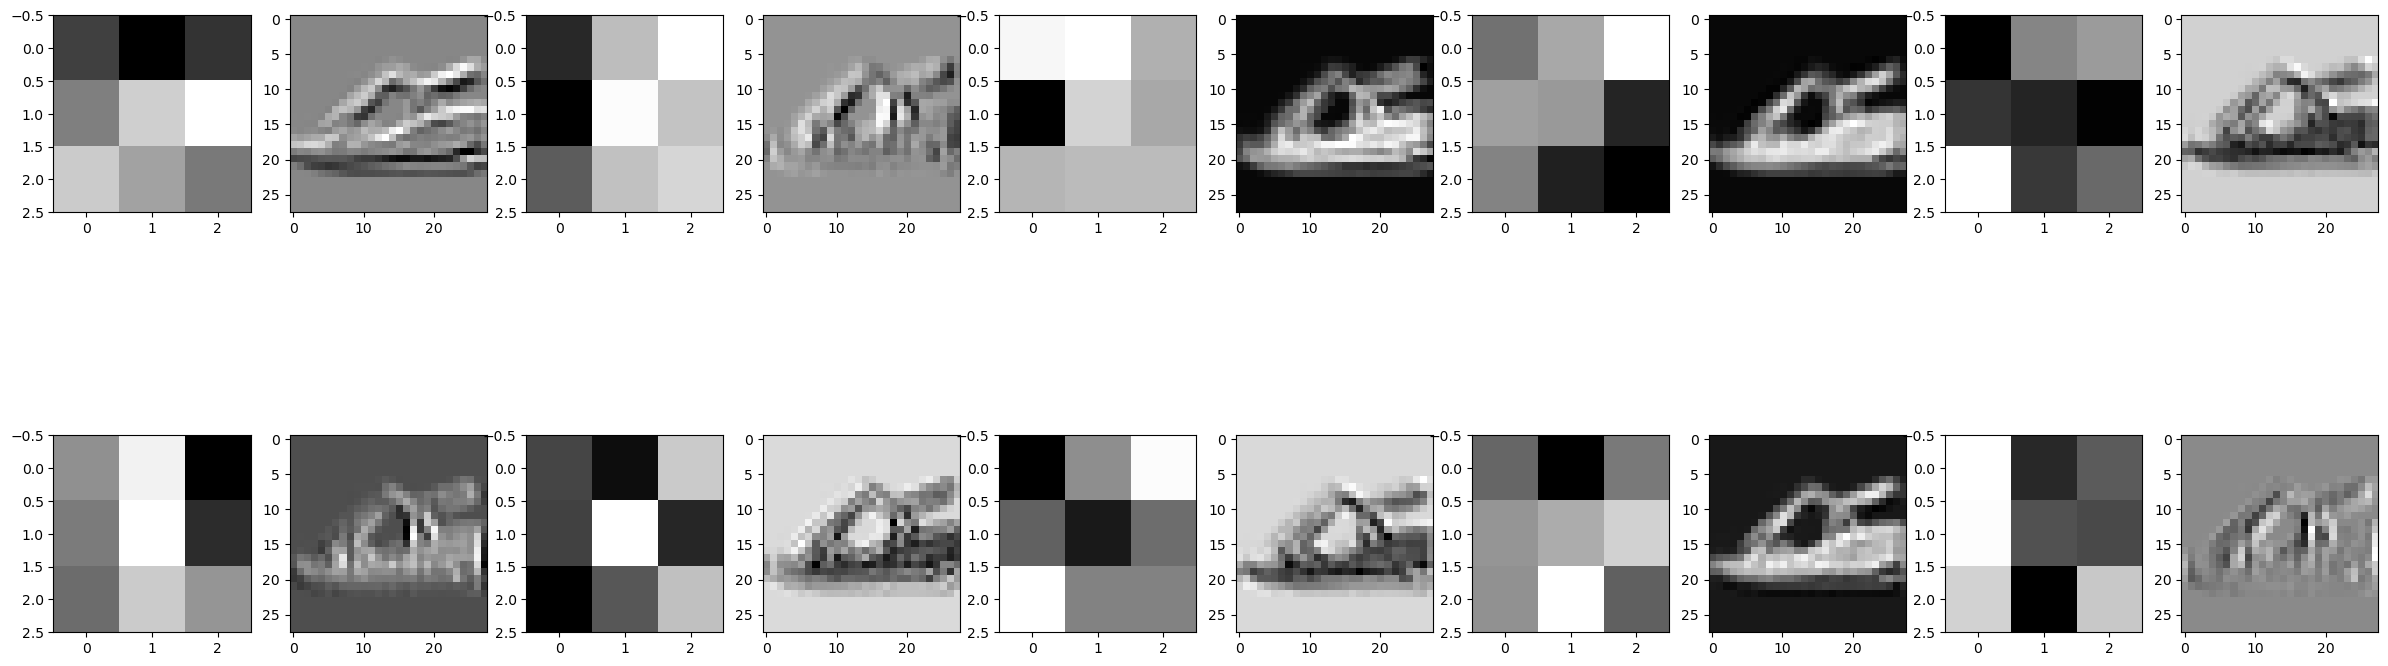

In [8]:
# obtain one batch of testing images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.numpy()

# select an image by index
idx = 10
img = np.squeeze(images[idx])

# Use OpenCV's filter2D function 
# apply a specific set of filter weights (like the one's displayed above) to the test image

import cv2
plt.imshow(img, cmap='gray')

weights = net.conv1.weight.data
w = weights.numpy()

# 1. first conv layer
# for 10 filters
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

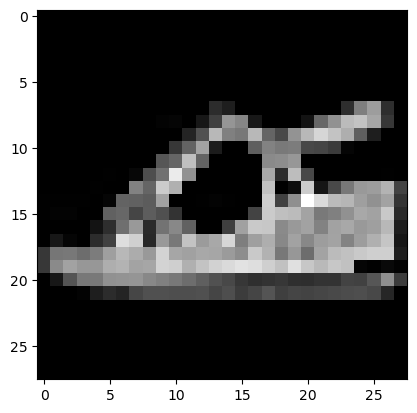

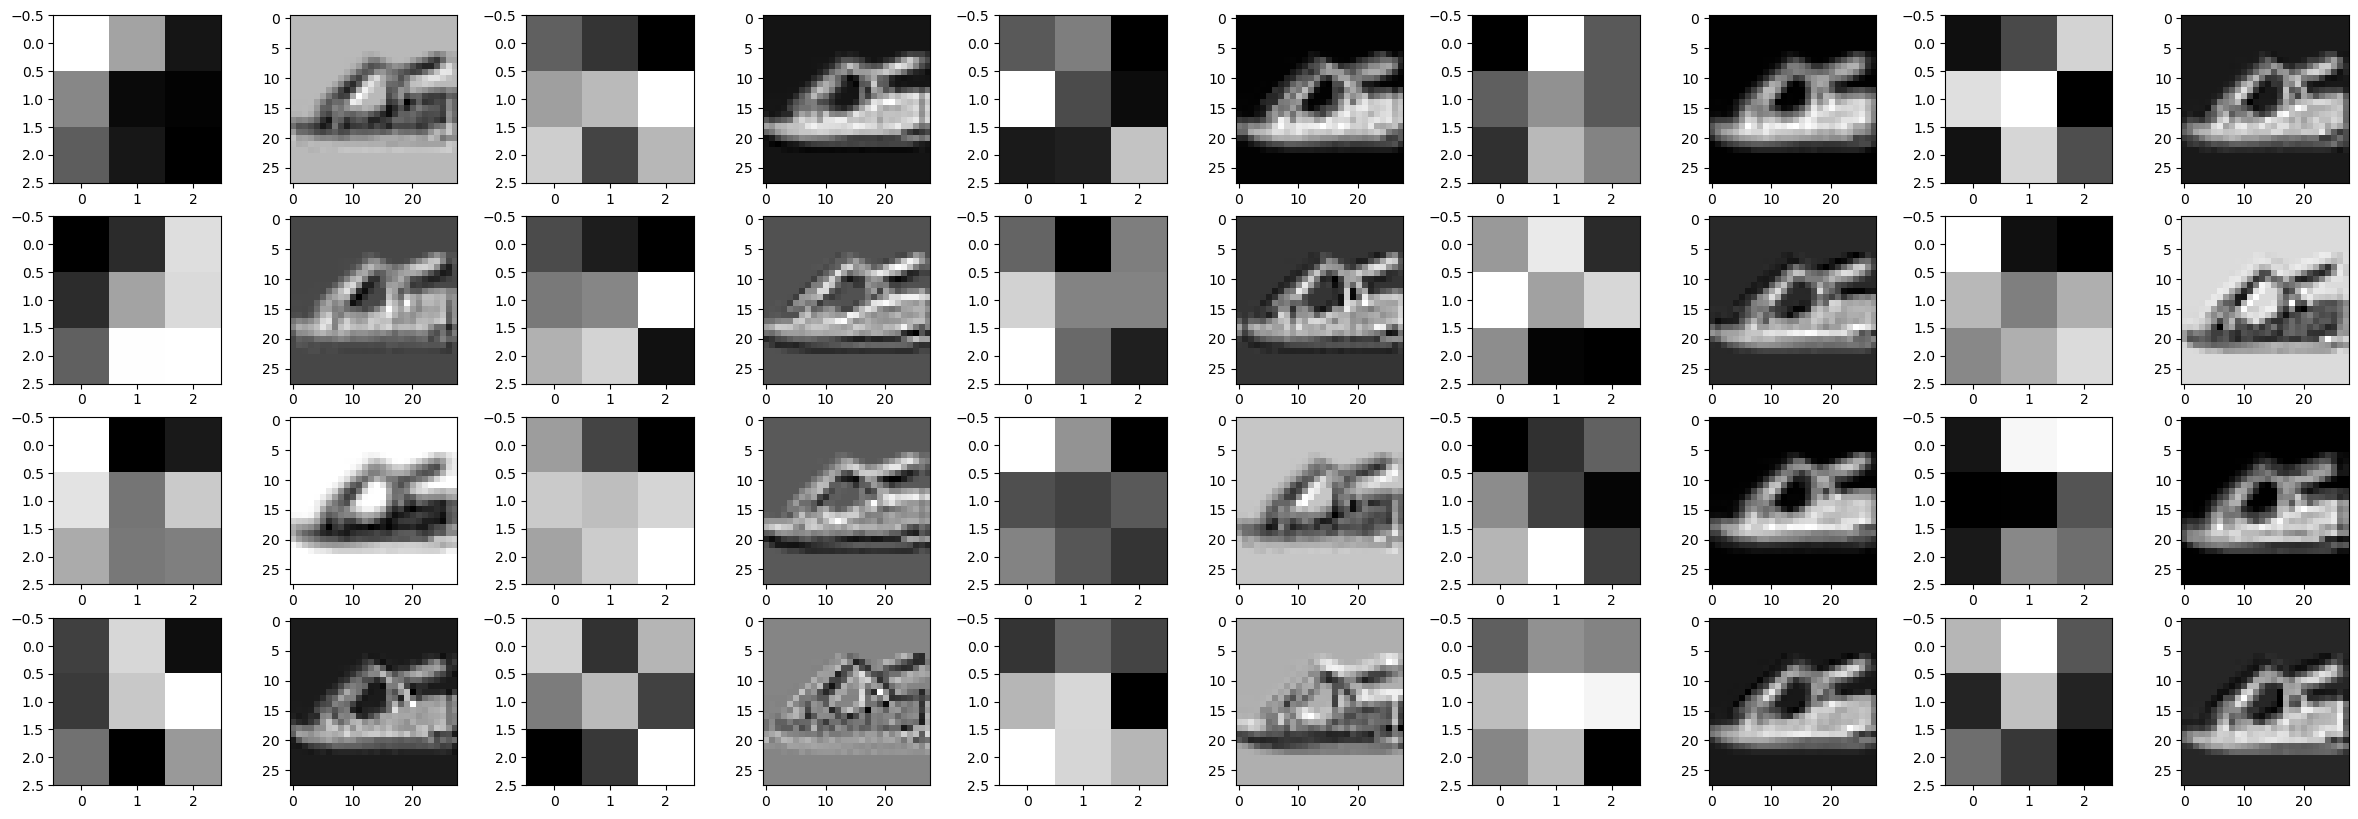

In [9]:
# Same process but for the second conv layer (20, 3x3 filters):
plt.imshow(img, cmap='gray')

# second conv layer, conv2
weights = net.conv2.weight.data
w = weights.numpy()

# 1. first conv layer
# for 20 filters
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2*2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

### Question: Choose a filter from one of your trained convolutional layers; looking at these activations, what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: In the first convolutional layer (conv1), the sixth filter, pictured as the first filter in the second row of the conv1 filters, appears to detect vertical/slightly-left leaning edges. It has a positively weighted left-most column and seems to detect the vertical edges of sleeves in a pullover.

In [10]:
w.shape

(20, 10, 3, 3)

In [11]:
w[0, 0]

array([[ 0.2132487 ,  0.06757395, -0.15576798],
       [ 0.02390015, -0.17427905, -0.18407401],
       [-0.04280071, -0.15311506, -0.19034062]], dtype=float32)